# Artificial Neural Network (Female)

In [1]:
#import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from keras.utils import np_utils
from tensorflow.keras import optimizers
%matplotlib inline

Using TensorFlow backend.


In [2]:
alzheimer = pd.read_csv('adni_ixi_rois_data_raw.csv', delimiter=',',header=0)
print(alzheimer.shape)
print(alzheimer.head())
print(alzheimer.info())
print(alzheimer.describe())

(2436, 453)
   lh_bankssts_area  lh_caudalanteriorcingulate_area  \
0               879                              528   
1               845                              525   
2               884                              605   
3               846                              612   
4               834                              324   

   lh_caudalmiddlefrontal_area  lh_cuneus_area  lh_entorhinal_area  \
0                         1968            1072                 253   
1                         1892            1064                 285   
2                         2093            1449                 524   
3                         2035            1485                 521   
4                         2140            1518                 309   

   lh_fusiform_area  lh_inferiorparietal_area  lh_inferiortemporal_area  \
0              2307                      3573                      2445   
1              2232                      3670                      2383   
2    

In [3]:
#Check for missign values
total=alzheimer.isnull().sum().sort_values(ascending=False)
percent = round(alzheimer.isnull().sum().sort_values(ascending = False)/len(alzheimer)*100, 2)
pd.concat([total, percent], axis = 1,keys= ['Total', 'Percent'])


,Total,Percent
Age,0,0.0
lh_superiortemporal_volume,0,0.0
lh_caudalmiddlefrontal_volume,0,0.0
lh_cuneus_volume,0,0.0
lh_entorhinal_volume,0,0.0
...,...,...
rh_superiortemporal_thickness,0,0.0
rh_supramarginal_thickness,0,0.0
rh_frontalpole_thickness,0,0.0
rh_temporalpole_thickness,0,0.0


In [4]:
#Remove attributes with 0s and systematically inconsistent
alzheimers=alzheimer.drop(['eTIV', '5th-Ventricle', 'Left-WM-hypointensities','Right-WM-hypointensities','non-WM-hypointensities','Left-non-WM-hypointensities','Right-non-WM-hypointensities','Left-vessel','Right-vessel','lhSurfaceHoles','rhSurfaceHoles','SurfaceHoles'], axis = 1)
print(alzheimers.shape)

noisefiltered=alzheimers[alzheimers['total CNR']>0.9]
print(noisefiltered.head())
print(noisefiltered.shape)

sortedfiltered=noisefiltered.sort_values('SID', ascending=False)
print(sortedfiltered.head())
print(sortedfiltered.shape)

(2436, 441)
   lh_bankssts_area  lh_caudalanteriorcingulate_area  \
0               879                              528   
1               845                              525   
2               884                              605   
3               846                              612   
4               834                              324   

   lh_caudalmiddlefrontal_area  lh_cuneus_area  lh_entorhinal_area  \
0                         1968            1072                 253   
1                         1892            1064                 285   
2                         2093            1449                 524   
3                         2035            1485                 521   
4                         2140            1518                 309   

   lh_fusiform_area  lh_inferiorparietal_area  lh_inferiortemporal_area  \
0              2307                      3573                      2445   
1              2232                      3670                      2383   
2    

In [5]:
#Filter out duplicate values, keeping the first value
duplicates=sortedfiltered.drop_duplicates(subset='SID',keep = 'first') 
print(duplicates.head())
print(duplicates.info())


      lh_bankssts_area  lh_caudalanteriorcingulate_area  \
2237              1382                              399   
2236              1031                              604   
2235              1115                              604   
2234               984                              601   
2233              1039                              514   

      lh_caudalmiddlefrontal_area  lh_cuneus_area  lh_entorhinal_area  \
2237                         2328            1713                 536   
2236                         2334            1628                 382   
2235                         2674            1805                 406   
2234                         2513            1494                 575   
2233                         2305            1964                 463   

      lh_fusiform_area  lh_inferiorparietal_area  lh_inferiortemporal_area  \
2237              4280                      5523                      4045   
2236              2709                      5016  

In [6]:
#Encode labels and drop unecessary columns
label_quality = LabelEncoder()
duplicates['Research Group'] = label_quality.fit_transform(duplicates['Research Group'])
train=duplicates.copy()
train.drop(['Age','SID', 'total CNR','Study'], axis=1, inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1215 entries, 2237 to 767
Columns: 437 entries, lh_bankssts_area to Research Group
dtypes: float64(284), int64(152), object(1)
memory usage: 4.1+ MB


/home/fs838120/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
#filter out by male and female
male=train[train['Gender']=='M']
male.shape
male.head()
male.info()

female=train[train['Gender']=='F']
female.shape
female.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 575 entries, 2237 to 767
Columns: 437 entries, lh_bankssts_area to Research Group
dtypes: float64(284), int64(152), object(1)
memory usage: 1.9+ MB


,lh_bankssts_area,lh_caudalanteriorcingulate_area,lh_caudalmiddlefrontal_area,lh_cuneus_area,lh_entorhinal_area,lh_fusiform_area,lh_inferiorparietal_area,lh_inferiortemporal_area,lh_isthmuscingulate_area,lh_lateraloccipital_area,...,right_parasubiculum,right_molecular_layer_HP,right_GC-ML-DG,right_CA3,right_CA4,right_fimbria,right_HATA,right_Whole_hippocampus,Gender,Research Group
2220,862,530,2037,1289,535,2929,3952,3047,819,4568,...,46.461919,434.595503,231.404698,162.388210,197.017748,70.285099,56.145862,2857.525319,F,1
2219,816,547,2181,1408,513,2911,3146,2675,838,4583,...,50.964043,539.436587,284.107845,190.369238,238.195497,79.764626,66.806796,3344.279277,F,1
2216,899,607,1827,1365,378,3123,4316,3046,787,5403,...,32.580984,532.200366,292.456888,210.220181,250.866354,33.304657,62.685547,3150.591207,F,1
2210,880,779,1821,1507,375,3069,4479,3630,925,4488,...,48.457593,581.810977,327.605965,251.333255,279.380102,59.665453,54.737106,3514.416839,F,1
2208,859,571,1602,1272,264,2551,3907,2887,711,4722,...,39.616299,461.266237,260.890460,199.302961,220.133679,43.914119,47.364900,2811.495889,F,1


In [8]:
#Drop category labels and gender labels
y_female = female["Research Group"]
X_female = female.drop(["Research Group",'Gender'], axis = 1)

In [9]:
#Normalise the data between 0 and 1
sc=StandardScaler()
X_scaled_female = sc.fit_transform(X_female)

In [10]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_female, y_female,test_size = 0.3, random_state=42)   #scale the test data as well
#Train Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [60]:
#Build sequential model
model = Sequential()
model.add(Dense(435, input_dim=435, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.summary()


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 435)               189660    
_________________________________________________________________
dropout_34 (Dropout)         (None, 435)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 300)               130800    
_________________________________________________________________
dropout_35 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 150)               45150     
_________________________________________________________________
dropout_36 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 1)               

In [61]:
model.get_config()
model.get_weights()


[array([[ 0.04300438, -0.02083045,  0.0598651 , ...,  0.0516665 ,
          0.04989547, -0.07380145],
        [ 0.0446662 ,  0.07190421, -0.00620659, ..., -0.01348253,
         -0.01726391,  0.02285989],
        [ 0.01063925, -0.01189112,  0.02308962, ..., -0.03834239,
         -0.01050164, -0.06657858],
        ...,
        [-0.05622801,  0.00367342,  0.06045525, ..., -0.04973363,
          0.01042939,  0.07533832],
        [-0.03935944,  0.03502638,  0.05262275, ..., -0.01329655,
          0.065354  , -0.08222473],
        [-0.03607409, -0.08266783, -0.03620273, ..., -0.04374721,
         -0.06921946, -0.07015769]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [62]:
#Compile and fit the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
history=model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),verbose=1)

Train on 448 samples, validate on 90 samples
Epoch 1/50
448/448 [==============================] - 1s 2ms/sample - loss: 0.6511 - accuracy: 0.6964 - val_loss: 0.5747 - val_accuracy: 0.7444
Epoch 2/50
448/448 [==============================] - 0s 273us/sample - loss: 0.5979 - accuracy: 0.6786 - val_loss: 0.5413 - val_accuracy: 0.7778
Epoch 3/50
448/448 [==============================] - 0s 235us/sample - loss: 0.6033 - accuracy: 0.6786 - val_loss: 0.5152 - val_accuracy: 0.7889
Epoch 4/50
448/448 [==============================] - 0s 240us/sample - loss: 0.5676 - accuracy: 0.7299 - val_loss: 0.4947 - val_accuracy: 0.7778
Epoch 5/50
448/448 [==============================] - 0s 274us/sample - loss: 0.5426 - accuracy: 0.7344 - val_loss: 0.4755 - val_accuracy: 0.7889
Epoch 6/50
448/448 [==============================] - 0s 243us/sample - loss: 0.4954 - accuracy: 0.7634 - val_loss: 0.4597 - val_accuracy: 0.8222
Epoch 7/50
448/448 [==============================] - 0s 242us/sample - loss: 0.4

# Validation of the model

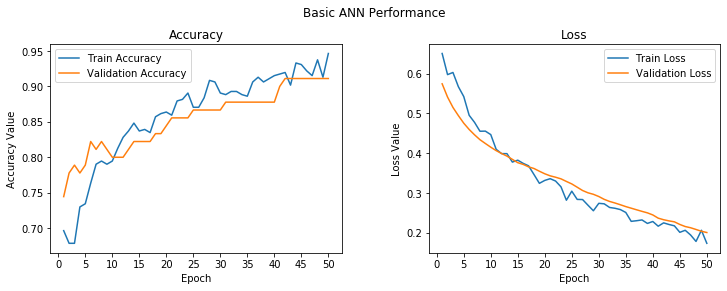

In [63]:
#Print out the statistics from the classifier
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic ANN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
#Plotting accuracy Statistics according to epoch
epoch_list = list(range(1,51))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 51, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 51, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [64]:
y_pred = model.predict(X_test)
print(y_pred)

[[0.9049393 ]
 [0.98281693]
 [0.49820137]
 [0.9896488 ]
 [0.7708135 ]
 [0.9854805 ]
 [0.98565096]
 [0.9985304 ]
 [0.97905123]
 [0.7640278 ]
 [0.06137561]
 [0.9656078 ]
 [0.9979234 ]
 [0.01736552]
 [0.44102463]
 [0.9298535 ]
 [0.24141221]
 [0.9972331 ]
 [0.27482384]
 [0.83262014]
 [0.93774956]
 [0.503048  ]
 [0.8962296 ]
 [0.9796448 ]
 [0.6243931 ]
 [0.98208076]
 [0.94280094]
 [0.8440062 ]
 [0.9996828 ]
 [0.9866752 ]
 [0.04943692]
 [0.80661416]
 [0.9945246 ]
 [0.99035734]
 [0.98832816]
 [0.00413434]
 [0.91491276]
 [0.9162455 ]
 [0.60088444]
 [0.9993316 ]
 [0.9710814 ]
 [0.99770385]
 [0.98312527]
 [0.9759074 ]
 [0.97948784]
 [0.0083202 ]
 [0.9905037 ]
 [0.9536256 ]
 [0.03646756]
 [0.8479559 ]
 [0.9983517 ]
 [0.95140314]
 [0.60156304]
 [0.99947244]
 [0.9874522 ]
 [0.8784155 ]
 [0.94186175]
 [0.997092  ]
 [0.9715992 ]
 [0.98781514]
 [0.09301697]
 [0.99729985]
 [0.29167625]
 [0.99812406]
 [0.9953289 ]
 [0.9958562 ]
 [0.99259174]
 [0.6098989 ]
 [0.9933856 ]
 [0.99561465]
 [0.99759513]
 [0.98

In [65]:
score = model.evaluate(X_test, y_test,verbose=1)
print(score)

192/192 [==============================] - 0s 932us/sample - loss: 0.1536 - accuracy: 0.9271
[0.15355310589075089, 0.9270833]


In [66]:
print(confusion_matrix(y_test, y_pred.round()))
print(classification_report(y_test,y_pred.round()))

[[ 40   9]
 [  5 138]]
              precision    recall  f1-score   support

           0       0.89      0.82      0.85        49
           1       0.94      0.97      0.95       143

    accuracy                           0.93       192
   macro avg       0.91      0.89      0.90       192
weighted avg       0.93      0.93      0.93       192



0.9798772655915513


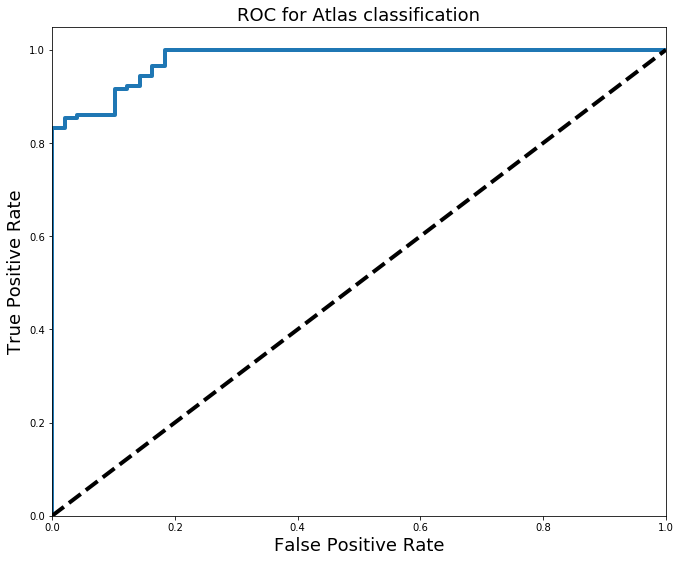

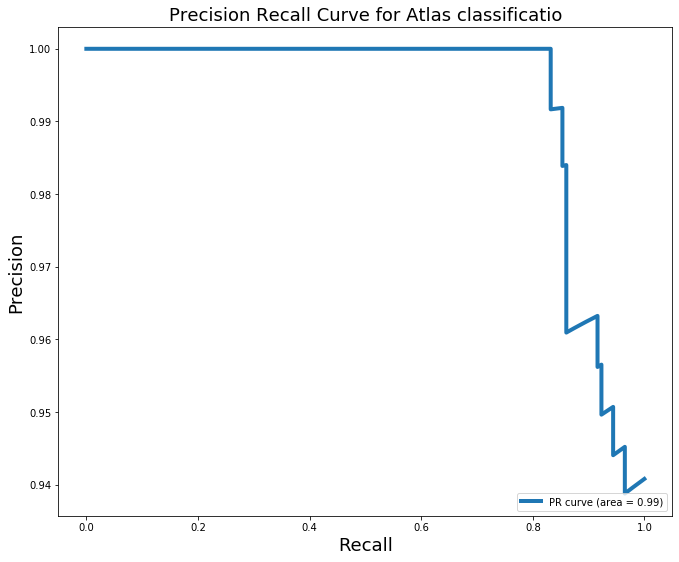

In [67]:
FPR, TPR, _ = roc_curve(y_test, y_pred)
ROC_AUC = auc(FPR, TPR)
print (ROC_AUC)

plt.figure(figsize =[11,9])
plt.plot(FPR, TPR, label= 'ROC curve(area = %0.2f)'%ROC_AUC, linewidth= 4)
plt.plot([0,1],[0,1], 'k--', linewidth = 4)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.title('ROC for Atlas classification', fontsize= 18)
plt.show()
#Precision recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
PR_AUC = auc(recall, precision)

plt.figure(figsize=[11,9])
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % PR_AUC, linewidth=4)
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision Recall Curve for Atlas classificatio', fontsize=18)
plt.legend(loc="lower right")
plt.show()

# Artificial neural network Cross Validation

In [69]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = Sequential()
    model.add(Dense(435, input_dim=435, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(300, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(150, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
    return model


In [70]:
#Repartition the normalised data
X_train, X_test, y_train, y_test = train_test_split(X_scaled_female, y_female,test_size = 0.3, random_state=42)

In [71]:
#Now with cross validation 10 fold
k = 10
num_val_samples = len(X_train) // k
num_epochs = 50
all_accuracy_history = []
for i in range(k):
    print('processing fold #', i+1)
    # Prepare the validation data: data from partition # k
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [X_train[:i * num_val_samples],
         X_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
        y_train[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=1)
    accuracy_history = history.history['accuracy']
    all_accuracy_history.append(accuracy_history)


processing fold # 1
Train on 404 samples, validate on 44 samples
Epoch 1/50
404/404 [==============================] - 3s 8ms/sample - loss: 0.6217 - accuracy: 0.6535 - val_loss: 0.4610 - val_accuracy: 0.8409
Epoch 2/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.4378 - accuracy: 0.7970 - val_loss: 0.4127 - val_accuracy: 0.8409
Epoch 3/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.3914 - accuracy: 0.8366 - val_loss: 0.3970 - val_accuracy: 0.8409
Epoch 4/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.3399 - accuracy: 0.8416 - val_loss: 0.3818 - val_accuracy: 0.8864
Epoch 5/50
404/404 [==============================] - 2s 5ms/sample - loss: 0.3577 - accuracy: 0.8663 - val_loss: 0.3829 - val_accuracy: 0.8864
Epoch 6/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.3193 - accuracy: 0.8738 - val_loss: 0.3928 - val_accuracy: 0.8864
Epoch 7/50
404/404 [==============================] - 2s 4ms/sample - l

Epoch 7/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.3339 - accuracy: 0.8787 - val_loss: 0.1877 - val_accuracy: 0.9091
Epoch 8/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.3610 - accuracy: 0.8515 - val_loss: 0.1783 - val_accuracy: 0.9091
Epoch 9/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.3043 - accuracy: 0.8936 - val_loss: 0.1704 - val_accuracy: 0.9091
Epoch 10/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.3061 - accuracy: 0.8738 - val_loss: 0.1565 - val_accuracy: 0.9091
Epoch 11/50
404/404 [==============================] - 2s 5ms/sample - loss: 0.2728 - accuracy: 0.8936 - val_loss: 0.1426 - val_accuracy: 0.9318
Epoch 12/50
404/404 [==============================] - 2s 5ms/sample - loss: 0.2655 - accuracy: 0.9035 - val_loss: 0.1325 - val_accuracy: 0.9545
Epoch 13/50
404/404 [==============================] - 2s 5ms/sample - loss: 0.2779 - accuracy: 0.8837 - val_loss: 0.1210 - val_accur

404/404 [==============================] - 2s 4ms/sample - loss: 0.2368 - accuracy: 0.9208 - val_loss: 0.2208 - val_accuracy: 0.9318
Epoch 14/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.2193 - accuracy: 0.9257 - val_loss: 0.2238 - val_accuracy: 0.9318
Epoch 15/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.1981 - accuracy: 0.9480 - val_loss: 0.2298 - val_accuracy: 0.9318
Epoch 16/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.2182 - accuracy: 0.9233 - val_loss: 0.2282 - val_accuracy: 0.9318
Epoch 17/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.1973 - accuracy: 0.9233 - val_loss: 0.2299 - val_accuracy: 0.9318
Epoch 18/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.1339 - accuracy: 0.9653 - val_loss: 0.2452 - val_accuracy: 0.9091
Epoch 19/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.1808 - accuracy: 0.9431 - val_loss: 0.2559 - val_accuracy: 0.90

404/404 [==============================] - 2s 4ms/sample - loss: 0.2035 - accuracy: 0.9332 - val_loss: 0.2072 - val_accuracy: 0.8864
Epoch 20/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.2089 - accuracy: 0.9381 - val_loss: 0.2022 - val_accuracy: 0.8864
Epoch 21/50
404/404 [==============================] - 2s 5ms/sample - loss: 0.1983 - accuracy: 0.9406 - val_loss: 0.2002 - val_accuracy: 0.8864
Epoch 22/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.1783 - accuracy: 0.9406 - val_loss: 0.1942 - val_accuracy: 0.8864
Epoch 23/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.1526 - accuracy: 0.9554 - val_loss: 0.1958 - val_accuracy: 0.9091
Epoch 24/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.1401 - accuracy: 0.9604 - val_loss: 0.2061 - val_accuracy: 0.9091
Epoch 25/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.1299 - accuracy: 0.9604 - val_loss: 0.2082 - val_accuracy: 0.90

404/404 [==============================] - 2s 4ms/sample - loss: 0.1345 - accuracy: 0.9678 - val_loss: 0.5255 - val_accuracy: 0.8864
Epoch 26/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.1075 - accuracy: 0.9728 - val_loss: 0.5273 - val_accuracy: 0.8864
Epoch 27/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.1100 - accuracy: 0.9678 - val_loss: 0.5383 - val_accuracy: 0.8864
Epoch 28/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.1134 - accuracy: 0.9678 - val_loss: 0.5536 - val_accuracy: 0.8864
Epoch 29/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.1161 - accuracy: 0.9629 - val_loss: 0.5566 - val_accuracy: 0.8864
Epoch 30/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.1370 - accuracy: 0.9579 - val_loss: 0.5652 - val_accuracy: 0.8864
Epoch 31/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.1270 - accuracy: 0.9629 - val_loss: 0.5785 - val_accuracy: 0.86

404/404 [==============================] - 2s 4ms/sample - loss: 0.0798 - accuracy: 0.9777 - val_loss: 0.9031 - val_accuracy: 0.8409
Epoch 32/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.0781 - accuracy: 0.9802 - val_loss: 0.9019 - val_accuracy: 0.8409
Epoch 33/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.0799 - accuracy: 0.9851 - val_loss: 0.9351 - val_accuracy: 0.8636
Epoch 34/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.0889 - accuracy: 0.9802 - val_loss: 0.9698 - val_accuracy: 0.8636
Epoch 35/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.0782 - accuracy: 0.9802 - val_loss: 0.9670 - val_accuracy: 0.8636
Epoch 36/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.0558 - accuracy: 0.9876 - val_loss: 1.0005 - val_accuracy: 0.8636
Epoch 37/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.0489 - accuracy: 0.9876 - val_loss: 1.0329 - val_accuracy: 0.86

404/404 [==============================] - 2s 4ms/sample - loss: 0.0872 - accuracy: 0.9752 - val_loss: 0.4449 - val_accuracy: 0.9091
Epoch 38/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.0896 - accuracy: 0.9752 - val_loss: 0.4461 - val_accuracy: 0.9091
Epoch 39/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.0923 - accuracy: 0.9752 - val_loss: 0.4638 - val_accuracy: 0.9091
Epoch 40/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.1000 - accuracy: 0.9752 - val_loss: 0.4718 - val_accuracy: 0.9091
Epoch 41/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.0546 - accuracy: 0.9827 - val_loss: 0.4838 - val_accuracy: 0.9091
Epoch 42/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.0948 - accuracy: 0.9777 - val_loss: 0.4974 - val_accuracy: 0.9091
Epoch 43/50
404/404 [==============================] - 2s 5ms/sample - loss: 0.0823 - accuracy: 0.9752 - val_loss: 0.5120 - val_accuracy: 0.90

404/404 [==============================] - 2s 4ms/sample - loss: 0.0695 - accuracy: 0.9752 - val_loss: 0.9141 - val_accuracy: 0.8636
Epoch 44/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.0605 - accuracy: 0.9851 - val_loss: 0.9543 - val_accuracy: 0.8636
Epoch 45/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.0476 - accuracy: 0.9876 - val_loss: 0.9693 - val_accuracy: 0.8636
Epoch 46/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.0938 - accuracy: 0.9851 - val_loss: 0.9972 - val_accuracy: 0.8636
Epoch 47/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.0505 - accuracy: 0.9851 - val_loss: 1.0525 - val_accuracy: 0.8636
Epoch 48/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.0524 - accuracy: 0.9851 - val_loss: 1.0580 - val_accuracy: 0.8636
Epoch 49/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.0885 - accuracy: 0.9827 - val_loss: 1.0566 - val_accuracy: 0.86

404/404 [==============================] - 2s 4ms/sample - loss: 0.0541 - accuracy: 0.9851 - val_loss: 0.3273 - val_accuracy: 0.9091
Epoch 50/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.0760 - accuracy: 0.9851 - val_loss: 0.3318 - val_accuracy: 0.9091
processing fold # 10
Train on 404 samples, validate on 44 samples
Epoch 1/50
404/404 [==============================] - 3s 7ms/sample - loss: 0.6231 - accuracy: 0.6683 - val_loss: 0.4522 - val_accuracy: 0.7727
Epoch 2/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.5045 - accuracy: 0.7525 - val_loss: 0.3871 - val_accuracy: 0.8182
Epoch 3/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.4236 - accuracy: 0.8193 - val_loss: 0.3716 - val_accuracy: 0.8409
Epoch 4/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.3588 - accuracy: 0.8564 - val_loss: 0.3699 - val_accuracy: 0.8182
Epoch 5/50
404/404 [==============================] - 2s 4ms/sample - loss: 0.33

In [72]:
average_accuracy_history = [
    np.mean([x[i] for x in all_accuracy_history]) for i in range(num_epochs)]

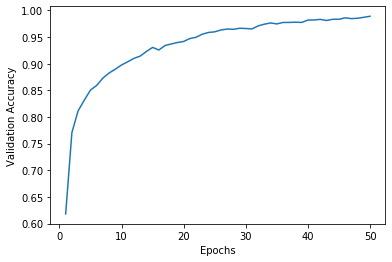

In [73]:
plt.plot(range(1, len(average_accuracy_history) + 1), average_accuracy_history)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

In [74]:
y_pred = model.predict(X_test)
print(y_pred)

[[9.93975461e-01]
 [9.99999762e-01]
 [8.08407307e-01]
 [9.99999881e-01]
 [9.94616568e-01]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [9.70612526e-01]
 [7.47781371e-07]
 [9.88427103e-01]
 [1.00000000e+00]
 [3.14292629e-05]
 [7.60259688e-01]
 [9.97258782e-01]
 [6.70036674e-01]
 [9.99999762e-01]
 [4.04740637e-03]
 [9.15166736e-01]
 [9.99982238e-01]
 [2.30495501e-02]
 [9.99979973e-01]
 [1.00000000e+00]
 [3.35571989e-02]
 [9.99999881e-01]
 [9.99999762e-01]
 [9.99587834e-01]
 [1.00000000e+00]
 [9.99998569e-01]
 [1.03655766e-05]
 [9.92129087e-01]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.84877978e-13]
 [9.99999166e-01]
 [9.99999881e-01]
 [9.99977827e-01]
 [1.00000000e+00]
 [9.99999166e-01]
 [1.00000000e+00]
 [9.99992013e-01]
 [1.00000000e+00]
 [9.99999881e-01]
 [4.98973804e-08]
 [1.00000000e+00]
 [1.00000000e+00]
 [4.04866369e-05]
 [9.94751751e-01]
 [1.00000000e+00]
 [1.00000000e+00]
 [9.99890566e-01]
 [1.00000000e+00]
 [1.00000000e+00]
 [9.915593

In [75]:
score = model.evaluate(X_test, y_test,verbose=1)
print(score)

192/192 [==============================] - 0s 911us/sample - loss: 0.1057 - accuracy: 0.9688
[0.10574469197793708, 0.96875]


In [76]:
print(confusion_matrix(y_test, y_pred.round()))
print(classification_report(y_test,y_pred.round()))

[[ 45   4]
 [  2 141]]
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        49
           1       0.97      0.99      0.98       143

    accuracy                           0.97       192
   macro avg       0.96      0.95      0.96       192
weighted avg       0.97      0.97      0.97       192



0.9941487084344228


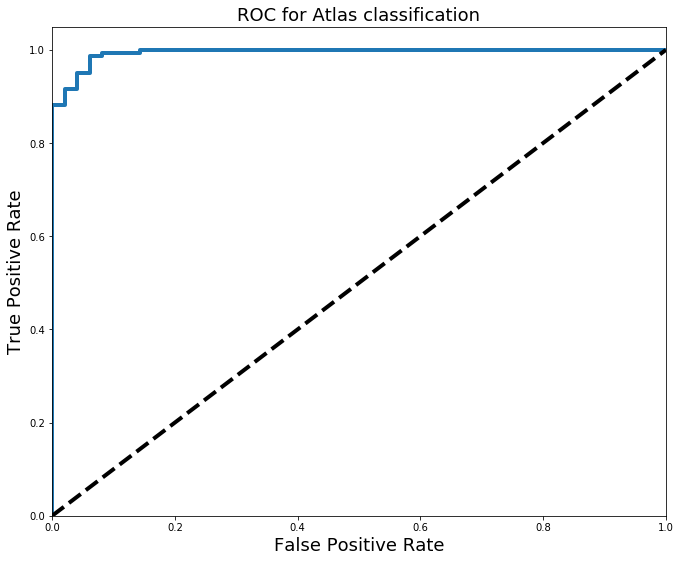

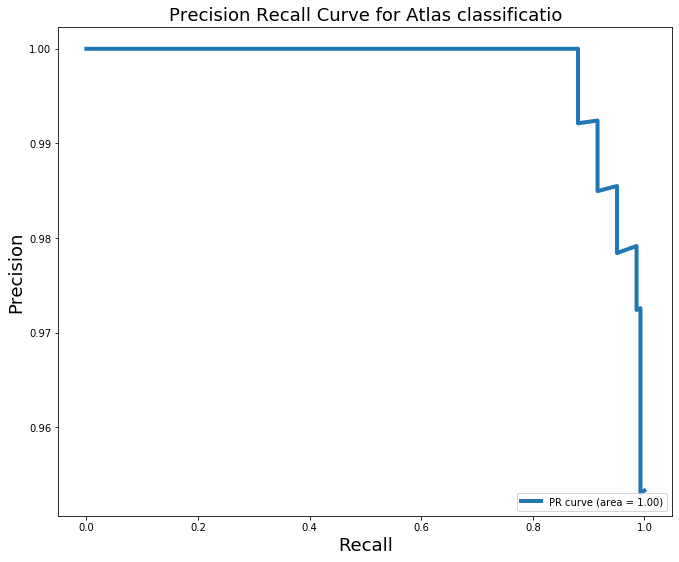

In [77]:
FPR, TPR, _ = roc_curve(y_test, y_pred)
ROC_AUC = auc(FPR, TPR)
print (ROC_AUC)

plt.figure(figsize =[11,9])
plt.plot(FPR, TPR, label= 'ROC curve(area = %0.2f)'%ROC_AUC, linewidth= 4)
plt.plot([0,1],[0,1], 'k--', linewidth = 4)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.title('ROC for Atlas classification', fontsize= 18)
plt.show()
#Precision recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
PR_AUC = auc(recall, precision)

plt.figure(figsize=[11,9])
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % PR_AUC, linewidth=4)
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision Recall Curve for Atlas classificatio', fontsize=18)
plt.legend(loc="lower right")
plt.show()